# [Independent optimization] Transcriptomic profile estimation with various sample size datasets

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import io

from sklearn.metrics.pairwise import cosine_similarity

# Plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 16

import sys
sys.path.append("../../scripts")
from noiseReductionMethodology import preprocessing, Raman_model
from analysis_pclda import LDA_model
from predictFunc import calcPrediction
from util import returnValues

import warnings
warnings.simplefilter('ignore', UserWarning)

## Load data

In [2]:
RAMAN = pd.read_csv("../../data/RAMAN_FINGERPRINT.csv")
TRANSCRIPTOME = pd.read_csv("../../data/TRANSCRIPTOME.csv")
RAMAN_PROCESSED = preprocessing(RAMAN)
RAMAN_PROCESSED.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,label
0,0.777427,0.798224,0.788404,0.760493,0.758397,0.730189,0.688064,0.620933,0.629037,0.658134,...,-1.786467,-1.778755,-1.773075,-1.801913,-1.817556,-1.802574,-1.790176,-1.800517,-1.835198,0
1,0.819071,0.838680,0.801314,0.734114,0.704192,0.677671,0.615264,0.532932,0.525684,0.557399,...,-1.942792,-1.988656,-2.001273,-2.014088,-2.021082,-2.015529,-1.991117,-1.972676,-1.962001,0
2,0.784357,0.799093,0.757752,0.689691,0.634893,0.599651,0.571955,0.523794,0.562298,0.624879,...,-1.856136,-1.828801,-1.792533,-1.794846,-1.801112,-1.815291,-1.843331,-1.893848,-1.902506,0
3,0.911177,0.947830,0.915633,0.857712,0.857826,0.800391,0.765022,0.717855,0.708535,0.691836,...,-1.736215,-1.723609,-1.730770,-1.767129,-1.791136,-1.787874,-1.769603,-1.755394,-1.783720,0
4,0.876973,0.864326,0.801489,0.735828,0.716139,0.703013,0.681590,0.651481,0.649721,0.639855,...,-1.958845,-1.995900,-2.030070,-2.019414,-2.005512,-1.999898,-2.020077,-2.048122,-2.082585,0


In [3]:
GROUP = [RAMAN_PROCESSED[RAMAN_PROCESSED["label"] == i].reset_index(drop=True) for i in range(RAMAN_PROCESSED["label"].max() + 1)]

In [4]:
colorList = ["gray", "#B51700"]
nameList = ["PCA", "NRM"]

In [5]:
numList = np.arange(12, 60, 6)

## Function

In [6]:
def generateDataList(n, GROUP=GROUP):
    RAMAN_dataList = []
    np.random.seed(0)
    for j in range(100):
        INPUTDATA = pd.DataFrame([])
        for OUT in GROUP:
            idxList = list(np.arange(OUT.shape[0]))
            np.random.shuffle(idxList)
            INPUTDATA = pd.concat([INPUTDATA, OUT.iloc[idxList[:n], :]], axis=0)
        INPUTDATA = INPUTDATA.reset_index(drop=True)

        RAMAN_dataList.append(INPUTDATA)
    return RAMAN_dataList

In [7]:
def performTranscriptomicProfileEstimation(dataList, cutPercentages):
    predict_dataList = []

    for RAMAN_DATA in dataList:
        print(".", end="")
        predict_list = []

        for cutDim in cutDims:
            raman_model = Raman_model(RAMAN_DATA, cutRange=cutDim, cutMode="dim")
            raman_model.calcTransformation()

            out = []
            for DATA in [raman_model.RAMAN_PCA, raman_model.RAMAN_NRM]:
                lda_model = LDA_model()
                DATA_LDA = lda_model.fit_transform(DATA)

                DATA_LDA = DATA_LDA.groupby("label").mean()
                DATA_LDA["label"] = np.arange(DATA_LDA.shape[0])

                PREDICT = calcPrediction(TRANSCRIPTOME, DATA_LDA, n_components=0, max_iter=50000)

                out.append(PREDICT)

            predict_list.append(out)

        predict_dataList.append(predict_list)
    print("")
    return predict_dataList

## Perform transcriptomic profile estimation

In [8]:
cutDims = np.arange(10, 151, 1)

### All data

In [9]:
predict_list = []

for cutDim in cutDims:
    print(".", end="")
    raman_model = Raman_model(RAMAN_PROCESSED, cutRange=cutDim, cutMode="dim")
    raman_model.calcTransformation()

    out = []
    for DATA in [raman_model.RAMAN_PCA, raman_model.RAMAN_NRM]:
        lda_model = LDA_model()
        DATA_LDA = lda_model.fit_transform(DATA)

        DATA_LDA = DATA_LDA.groupby("label").mean()
        DATA_LDA["label"] = np.arange(DATA_LDA.shape[0])

        PREDICT = calcPrediction(TRANSCRIPTOME, DATA_LDA, n_components=0, max_iter=50000)

        out.append(PREDICT)

    predict_list.append(out)

.............................................................................................................................................

In [11]:
SUMMARY_TABLE = pd.DataFrame(columns=[f"dim{i:.0f}" for i in cutDims]).T

out_pca = np.array([np.sum((returnValues(data[0]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1).sum()
                    for data in predict_list])

out_nrm = np.array([np.sum((returnValues(data[1]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1).sum()
                    for data in predict_list])
    

SUMMARY_TABLE["PRESS_PCA"] = out_pca
SUMMARY_TABLE["PRESS_NRM"] = out_nrm

SUMMARY_TABLE.to_csv("../../results/SUMMARY_DIM_SPOMBE.csv", index=True)
SUMMARY_TABLE.head()

,PRESS_PCA,PRESS_NRM
dim10,2.282061e+12,2.284896e+12
dim11,1.833732e+12,1.830418e+12
dim12,2.005527e+12,2.006969e+12
dim13,1.933379e+12,1.934123e+12
dim14,2.046011e+12,2.048360e+12


### Datasets with various sample sizes

**Note**:  
The following cell may take a long time to run, as it performs transcriptomic profile estimation across multiple sample sizes and dimensions.  
To save time, the corresponding precomputed results are already included in this repository at:  
 
`results/SUMMARY_DIM_SPOMBE_dataSize{n}.csv` (where `{n}` = 12, 18, 24, 30, 36)

You can skip this cell and directly load the corresponding summary tables from the `results/` directory.

In [10]:
for n in numList:
    print(f"[n = {n:>2}] ===================================")
    
    dataList = generateDataList(n)
    predict_dataList = performTranscriptomicProfileEstimation(dataList, cutDims)
    
    SUMMARY_TABLE = pd.DataFrame(columns=[f"dim{i:.0f}" for i in cutDims]).T
    
    out_pca = np.vstack([np.array([np.sum((returnValues(data[0]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1).sum()
                               for data in predict_list])
                     for predict_list in predict_dataList])

    out_nrm = np.vstack([np.array([np.sum((returnValues(data[1]) - returnValues(TRANSCRIPTOME)) ** 2, axis=1).sum()
                                   for data in predict_list])
                         for predict_list in predict_dataList])

    pList = np.array([stats.wilcoxon(a, b, alternative="two-sided").pvalue for a, b in zip(out_pca.T, out_nrm.T)])

    SUMMARY_TABLE["PRESS_PCA"] = np.mean(out_pca, axis=0)
    SUMMARY_TABLE["PRESS_NRM"] = np.mean(out_nrm, axis=0)
    SUMMARY_TABLE["PRESS_diff"] = np.mean(out_pca - out_nrm, axis=0)

    SUMMARY_TABLE.to_csv(f"../../results/SUMMARY_DIM_SPOMBE_dataSize{n}.csv", index=True)
    
    print(f"============================================")

[n = 12] ===================================
....................................................................................................
[n = 18] ===================================
....................................................................................................
[n = 24] ===================================
....................................................................................................
[n = 30] ===================================
....................................................................................................
[n = 36] ===================================
....................................................................................................
[n = 42] ===================================
....................................................................................................
[n = 48] ===================================
...............................................................................

## Performance comparison with the independently optimized dimensions

In [9]:
nListStr = np.hstack(["All", numList[::-1]]).astype(str)

In [10]:
SUMMARY_INDEPENDENT= pd.DataFrame([])

for n in nListStr:
    if n == "All":
        ALL = pd.read_csv("../../results/SUMMARY_DIM_SPOMBE.csv", index_col=0)
        OUT = ALL.sort_values(["PRESS_PCA"]).reset_index(drop=False).loc[[0], :]
        OUT_NRM = ALL.sort_values(["PRESS_NRM"]).reset_index(drop=False).loc[[0], :]
        OUT.loc[:, ["PRESS_NRM"]] = OUT_NRM.loc[:, ["PRESS_NRM"]]
        OUT["index_NRM"] = OUT_NRM["index"]
    else:
        ALL = pd.read_csv(f"../../results/SUMMARY_DIM_SPOMBE_dataSize{n}.csv", index_col=0)
        OUT = ALL.sort_values(["PRESS_PCA"]).reset_index(drop=False).loc[[0], :]
        OUT_NRM = ALL.sort_values(["PRESS_NRM"]).reset_index(drop=False).loc[[0], :]
        OUT.loc[:, ["PRESS_NRM"]] = OUT_NRM.loc[:, ["PRESS_NRM"]]
        OUT["index_NRM"] = OUT_NRM["index"]
    
    OUT["sampleSize"] = n
    SUMMARY_INDEPENDENT = pd.concat([SUMMARY_INDEPENDENT, OUT], axis=0, ignore_index=True)
    
SUMMARY_INDEPENDENT["PRESS_diff"] = SUMMARY_INDEPENDENT["PRESS_NRM"] - SUMMARY_INDEPENDENT["PRESS_PCA"]
SUMMARY_INDEPENDENT.head()

,index,PRESS_PCA,PRESS_NRM,index_NRM,sampleSize,PRESS_diff
0,dim94,1.393756e+12,1.389321e+12,dim103,All,-4.435234e+09
1,dim101,1.458139e+12,1.455164e+12,dim101,54,-2.974860e+09
2,dim110,1.456532e+12,1.452788e+12,dim110,48,-3.743900e+09
3,dim117,1.455341e+12,1.451687e+12,dim117,42,-3.653747e+09
4,dim102,1.472385e+12,1.468155e+12,dim102,36,-4.229458e+09


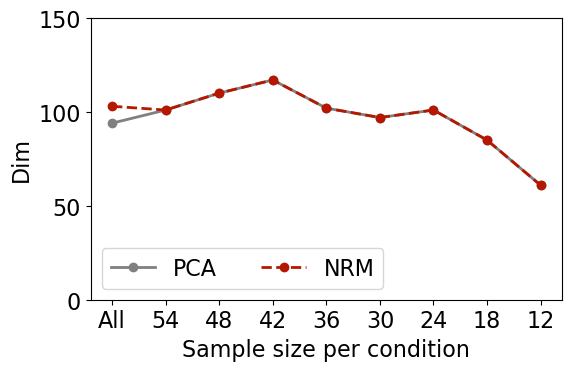

In [11]:
fig = plt.figure(figsize=(6, 4))

for name, color, idx, linestyle in zip(nameList, colorList, ["index", "index_NRM"], ["-", "--"]):
    plt.plot(np.array([a.replace("dim","") for a in SUMMARY_INDEPENDENT[idx].values]).astype(float),
             linewidth=2, marker="o", color=color, linestyle=linestyle, label=name)

plt.xticks(range(len(nListStr)), nListStr)
plt.xlim(-0.4, len(nListStr) - 1 + 0.4)
plt.xlabel("Sample size per condition")
plt.yticks(np.arange(0, 151, 50))
plt.ylabel("Dim")
plt.legend(ncol=2, loc="lower left")
plt.tight_layout()
plt.show()

In [12]:
SUMMARY_INDEPENDENT["PRESS_diff_std"] = np.nan
SUMMARY_INDEPENDENT["PRESS_pVal"] = np.nan
for idx_PCA, idx_NRM, n in SUMMARY_INDEPENDENT[["index", "index_NRM", "sampleSize"]].values:
    idx_PCA = int(idx_PCA.replace("dim", ""))
    idx_NRM = int(idx_NRM.replace("dim", ""))
    
    print(".", end="")
    if n == "All":
        continue
    else:
        n = int(n)
        dataList = generateDataList(n)
        
        
        predict_list = []
        
        for i, cutDim in enumerate([idx_PCA, idx_NRM]):
            out = []
            for RAMAN_DATA in dataList:
                raman_model = Raman_model(RAMAN_DATA, cutRange=cutDim, cutMode="dim")
                raman_model.calcTransformation()

                if i == 0:
                    DATA = raman_model.RAMAN_PCA
                else:
                    DATA = raman_model.RAMAN_NRM
                    
                lda_model = LDA_model()
                DATA_LDA = lda_model.fit_transform(DATA)

                DATA_LDA = DATA_LDA.groupby("label").mean()
                DATA_LDA["label"] = np.arange(DATA_LDA.shape[0])

                PREDICT = calcPrediction(TRANSCRIPTOME, DATA_LDA, n_components=0, max_iter=50000)

                out.append(PREDICT)

            out_val = np.array([np.sum((returnValues(data) - returnValues(TRANSCRIPTOME)) ** 2, axis=1).sum()
                                for data in out])
                                
            predict_list.append(out_val)
            
    SUMMARY_INDEPENDENT.loc[SUMMARY_INDEPENDENT["sampleSize"] == str(n), ["PRESS_diff_std"]] = np.std(predict_list[1] - predict_list[0])
    SUMMARY_INDEPENDENT.loc[SUMMARY_INDEPENDENT["sampleSize"] == str(n), ["PRESS_pVal"]] = stats.wilcoxon(predict_list[0], predict_list[1], alternative="two-sided").pvalue

.........

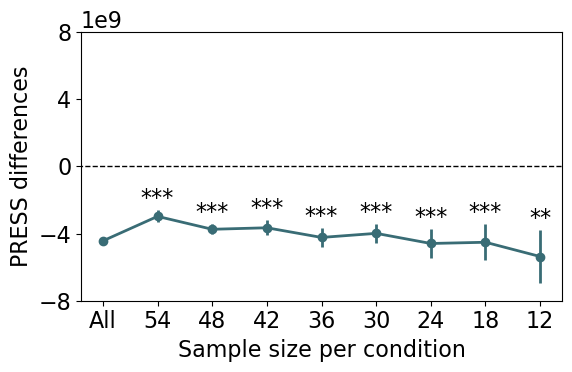

In [14]:
diff_mean = SUMMARY_INDEPENDENT["PRESS_diff"].values
diff_pval = SUMMARY_INDEPENDENT["PRESS_pVal"].values
diff_std = SUMMARY_INDEPENDENT["PRESS_diff_std"].values / np.sqrt(100)

plt.figure(figsize=(6, 4))
plt.errorbar(range(len(diff_mean)), diff_mean, yerr=diff_std, marker="o", color="#396C75",
             linewidth=2)


for i, (p, y, y_) in enumerate(zip(diff_pval, diff_mean, diff_std)):
    p *= (len(diff_mean) - 1)
    text = ""
    if p < 0.001:
        text = "***"
    elif p < 0.01:
        text = "**"
    elif p < 0.05:
        text = "*"
        
    plt.text(i, y + y_, text, ha="center", va="bottom")
    
plt.hlines(0, -1, len(nListStr), color="k", linewidth=1, zorder=0, linestyle="dashed")

plt.xticks(range(len(nListStr)), nListStr)
plt.xlim(-0.4, len(nListStr) - 1 + 0.4)
plt.yticks(np.arange(-8, 9, 4) * 1e9)
plt.ylim(-8e9, 8e9)
plt.xlabel("Sample size per condition")
plt.ylabel("PRESS differences")
plt.tight_layout()
plt.show()